In [ ]:
import os
import wfdb
import numpy as np
from scipy.linalg import qr
import matplotlib.pyplot as plt
from scipy.signal import correlate
from tqdm import tqdm

In [ ]:
# Updated data directory structure
data_dir = r'C:\Users\dylan\Documents\py-dev\EfficientAI\ecg_reconstruction\data\categorized'

In [ ]:
def align_signals(signals):
    """Align signals using cross-correlation"""
    ref = signals[:, 0]  # Use first signal as reference
    aligned = []
    for s in signals.T:
        corr = correlate(ref, s, mode='same')
        shift = np.argmax(corr) - len(ref)//2
        aligned.append(np.roll(s, -shift))
    return np.column_stack(aligned)

In [ ]:
def load_signals_from_all_dirs(num_records, sampling_rate=500, superclass='NORM'):
    """Load signals from all numbered directories (00000-21000) for a superclass"""
    signals = []
    record_prefix = 'hr' if sampling_rate == 500 else 'lr'
    base_path = os.path.join(data_dir, f"records{sampling_rate}")

    # Get all numbered directories (00000-21000)
    numbered_dirs = sorted([d for d in os.listdir(base_path)
                          if len(d) == 5 and d.isdigit()])

    for dir_num in tqdm(numbered_dirs, desc=f"Scanning {superclass} directories"):
        superclass_path = os.path.join(base_path, dir_num, 'super', superclass)
        if not os.path.exists(superclass_path):
            continue

        # Get available records in this directory
        record_files = [f for f in os.listdir(superclass_path)
                      if f.endswith('.hea')][:num_records - len(signals)]

        for record_file in record_files:
            record_id = record_file.split('_')[0]
            record_path = os.path.join(superclass_path, f"{record_id}_{record_prefix}")
            try:
                record = wfdb.rdrecord(record_path)
                signal = record.p_signal[:, 1]  # Lead II
                signals.append(signal / np.max(np.abs(signal)))  # Normalized
                if len(signals) >= num_records:
                    break
            except Exception as e:
                print(f"Skipping {record_path}: {str(e)}")
                continue
        if len(signals) >= num_records:
            break

    if not signals:
        return None

    X = np.column_stack(signals)
    return align_signals(X)

In [ ]:
def train_model(X, rank=50):
    """Train SVD model with regularization"""
    U, S, _ = np.linalg.svd(X, full_matrices=False)

    # Plot singular values for diagnosis
    #plt.figure(figsize=(10, 4))
    #plt.plot(S[:100], 'o-')  # First 100 singular values
    #plt.title(f'Singular Values (First {rank} shown)')
    #plt.axvline(x=rank, color='r', linestyle='--', label=f'Selected rank={rank}')
    #plt.legend()
    #plt.show()

    U_r = U[:, :rank]
    Q, R, pivots = qr(U_r.T, pivoting=True)
    C = np.zeros((rank, X.shape[0]))
    C[np.arange(rank), pivots[:rank]] = 1

    return U_r, C, pivots[:rank]

In [ ]:
def reconstruct_signal(test_signal, U_r, C):
    """Reconstruct signal with regularization"""
    y = C @ test_signal
    a = np.linalg.lstsq(C @ U_r + 1e-6*np.eye(U_r.shape[1]), y, rcond=None)[0]
    return U_r @ a

In [ ]:
def find_test_record(test_record, sampling_rate, superclass):
    """Search all directories for a test record"""
    record_prefix = 'hr' if sampling_rate == 500 else 'lr'
    base_path = os.path.join(data_dir, f"records{sampling_rate}")

    for dir_num in os.listdir(base_path):
        if len(dir_num) != 5 or not dir_num.isdigit():
            continue

        test_path = os.path.join(base_path, dir_num, 'super', superclass,
                               f"{test_record:05d}_{record_prefix}")
        if os.path.exists(test_path + '.hea'):
            try:
                test_signal = wfdb.rdrecord(test_path).p_signal[:, 1]
                return test_signal / np.max(np.abs(test_signal))
            except:
                continue
    return None

In [ ]:
def analyze_superclass_all_dirs(test_record, sampling_rate=500, num_train_records=500,
                               rank=25, superclass='NORM'):
    """Full analysis pipeline using all numbered directories (simplified visualization)"""
    # Load training data from all directories
    print(f"\nLoading {num_train_records} {superclass} records from all directories...")
    X = load_signals_from_all_dirs(num_train_records, sampling_rate, superclass)
    if X is None:
        raise ValueError(f"No signals found for {superclass} in any directory")

    # Train model
    print("Training model...")
    U_r, C, pivots = train_model(X, rank)

    # Find test record across all directories
    print(f"Locating test record {test_record}...")
    test_signal = find_test_record(test_record, sampling_rate, superclass)
    if test_signal is None:
        raise ValueError(f"Test record {test_record} not found in any {superclass} directory")

    # Reconstruct
    print("Reconstructing signal...")
    x_recon = reconstruct_signal(test_signal, U_r, C)
    mse = np.mean((test_signal - x_recon)**2)

    # Plot results: simplified to original, sample points, reconstructed
    plt.figure(figsize=(15, 6))

    # Original signal
    plt.subplot(3, 1, 1)
    plt.plot(test_signal, color='#1f77b4')
    plt.title('Original Signal')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)

    # Sample points
    plt.subplot(3, 1, 2)
    plt.plot(test_signal, color='#a5c8e4', alpha=0.5)
    plt.scatter(pivots, test_signal[pivots], color='red', s=40, label=f'Sampled Points (rank={rank})')
    plt.title('Sampled Points')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Reconstructed signal
    plt.subplot(3, 1, 3)
    plt.plot(x_recon, color='#d62728')
    plt.title(f'Reconstructed Signal (MSE: {mse:.4f})')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nAnalysis complete")
    print(f"Superclass: {superclass}")
    print(f"Test Record: {test_record}")
    print(f"Sampling Rate: {sampling_rate}Hz")
    print(f"Training Records Used: {X.shape[1]}")
    print(f"Rank: {rank}")
    print(f"MSE: {mse:.4f}")
    # print(f"Selected sample points: {pivots}")

    return mse


Loading 1000 HYP records from all directories...


Scanning HYP directories:  36%|███▋      | 8/22 [00:08<00:15,  1.07s/it]


Training model...
Locating test record 10002...
Reconstructing signal...


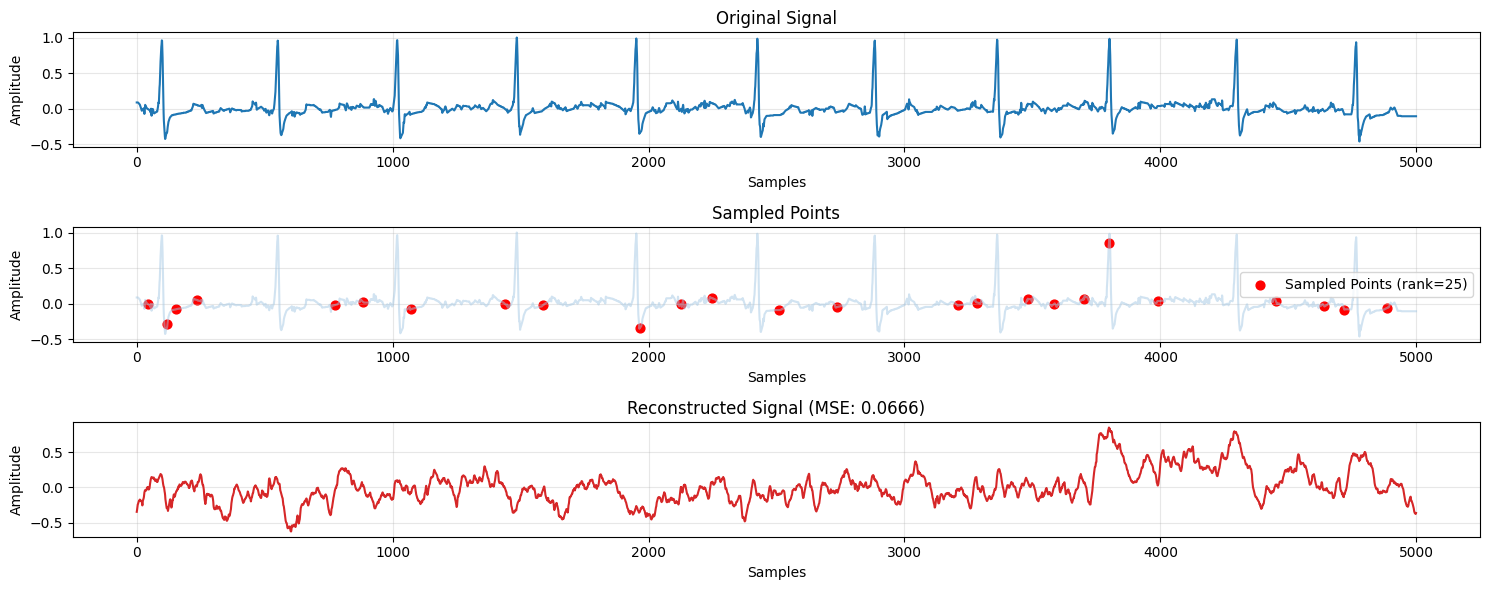


Analysis complete
Superclass: HYP
Test Record: 10002
Sampling Rate: 500Hz
Training Records Used: 1000
Rank: 25
MSE: 0.0666


np.float64(0.06661220014267144)

In [ ]:
analyze_superclass_all_dirs(
        test_record=10002,
        sampling_rate=500,
        num_train_records=1000,
        rank=25,
        superclass='HYP'
    )


Loading 1000 HYP records from all directories...


Scanning HYP directories:  36%|███▋      | 8/22 [00:01<00:02,  4.93it/s]


Training model...
Locating test record 10002...
Reconstructing signal...


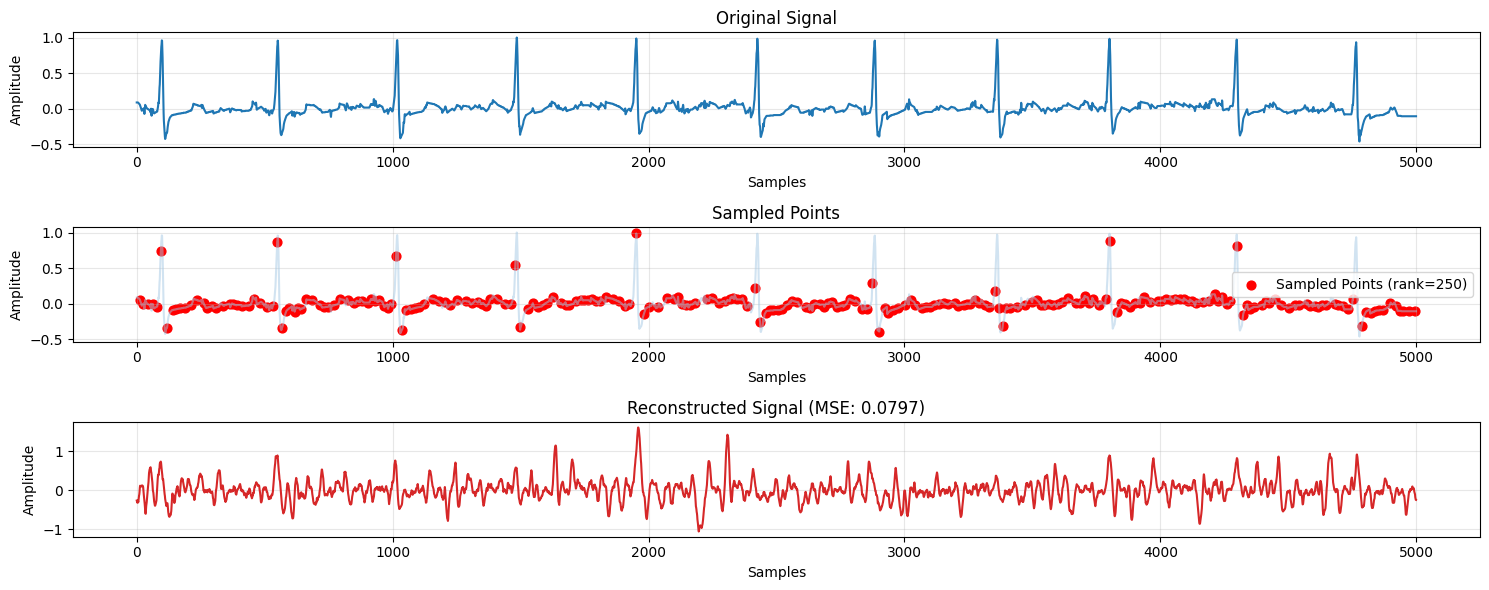


Analysis complete
Superclass: HYP
Test Record: 10002
Sampling Rate: 500Hz
Training Records Used: 1000
Rank: 250
MSE: 0.0797


np.float64(0.0797220297903745)

In [ ]:
analyze_superclass_all_dirs(
        test_record=10002,
        sampling_rate=500,
        num_train_records=1000,
        rank=250,
        superclass='HYP'
    )


Loading 1000 HYP records from all directories...


Scanning HYP directories:  36%|███▋      | 8/22 [00:01<00:02,  4.95it/s]


Training model...
Locating test record 10002...
Reconstructing signal...


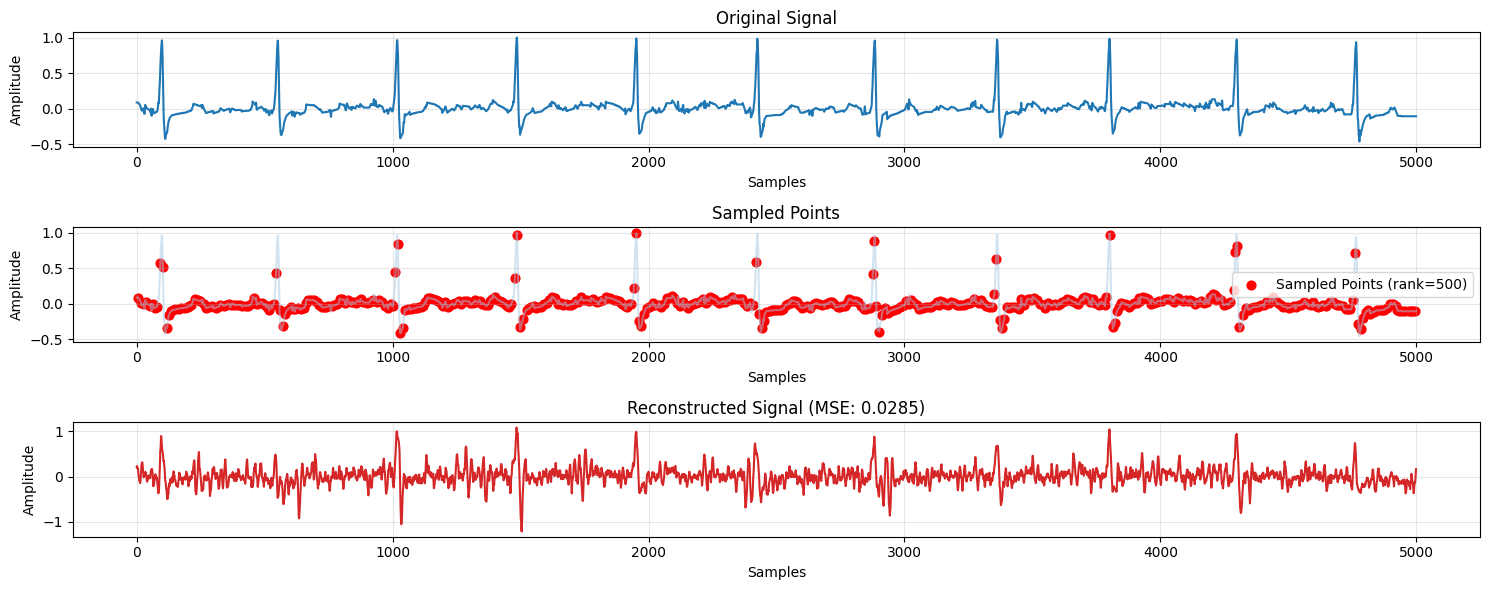


Analysis complete
Superclass: HYP
Test Record: 10002
Sampling Rate: 500Hz
Training Records Used: 1000
Rank: 500
MSE: 0.0285


np.float64(0.02849434929275378)

In [ ]:
analyze_superclass_all_dirs(
        test_record=10002,
        sampling_rate=500,
        num_train_records=1000,
        rank=500,
        superclass='HYP'
    )


Loading 1250 HYP records from all directories...


Scanning HYP directories:  45%|████▌     | 10/22 [00:03<00:04,  2.63it/s]


Training model...
Locating test record 10002...
Reconstructing signal...


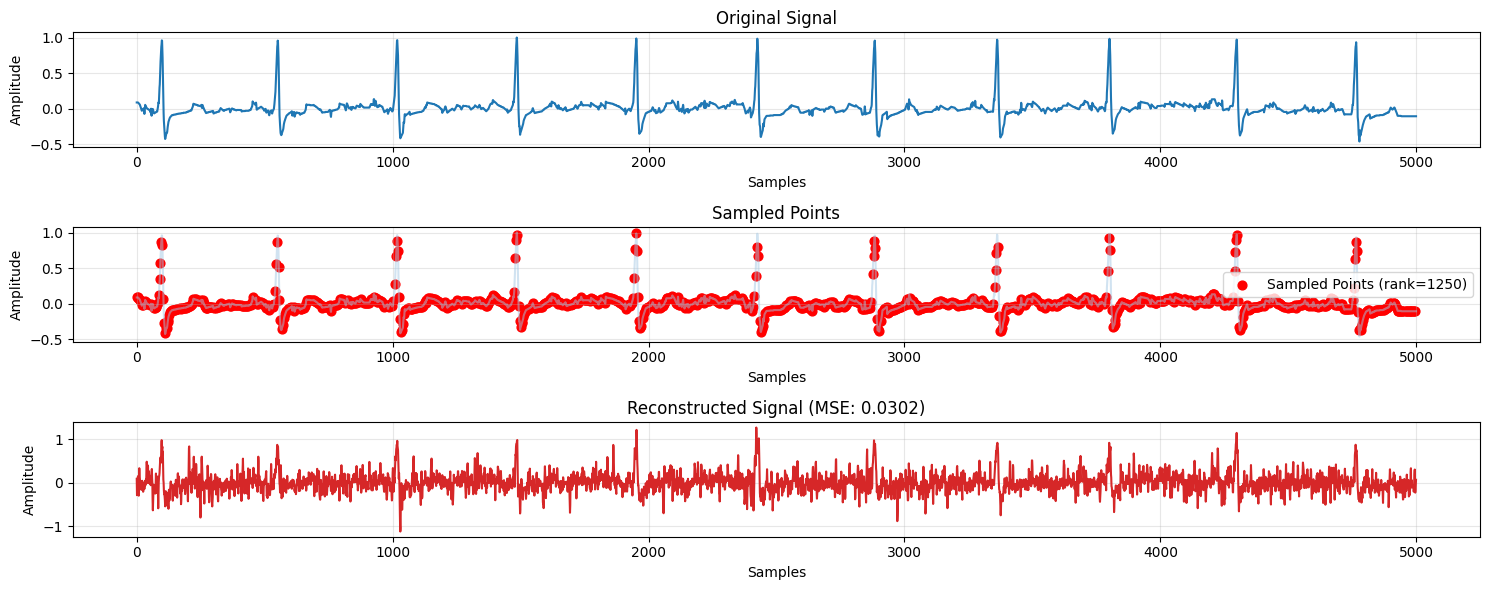


Analysis complete
Superclass: HYP
Test Record: 10002
Sampling Rate: 500Hz
Training Records Used: 1250
Rank: 1250
MSE: 0.0302


np.float64(0.03023099163124384)

In [ ]:
analyze_superclass_all_dirs(
        test_record=10002,
        sampling_rate=500,
        num_train_records=1250,
        rank=1250,
        superclass='HYP'
    )


Loading 2500 HYP records from all directories...


Scanning HYP directories:  91%|█████████ | 20/22 [00:04<00:00,  4.99it/s]


Training model...
Locating test record 21797...
Reconstructing signal...


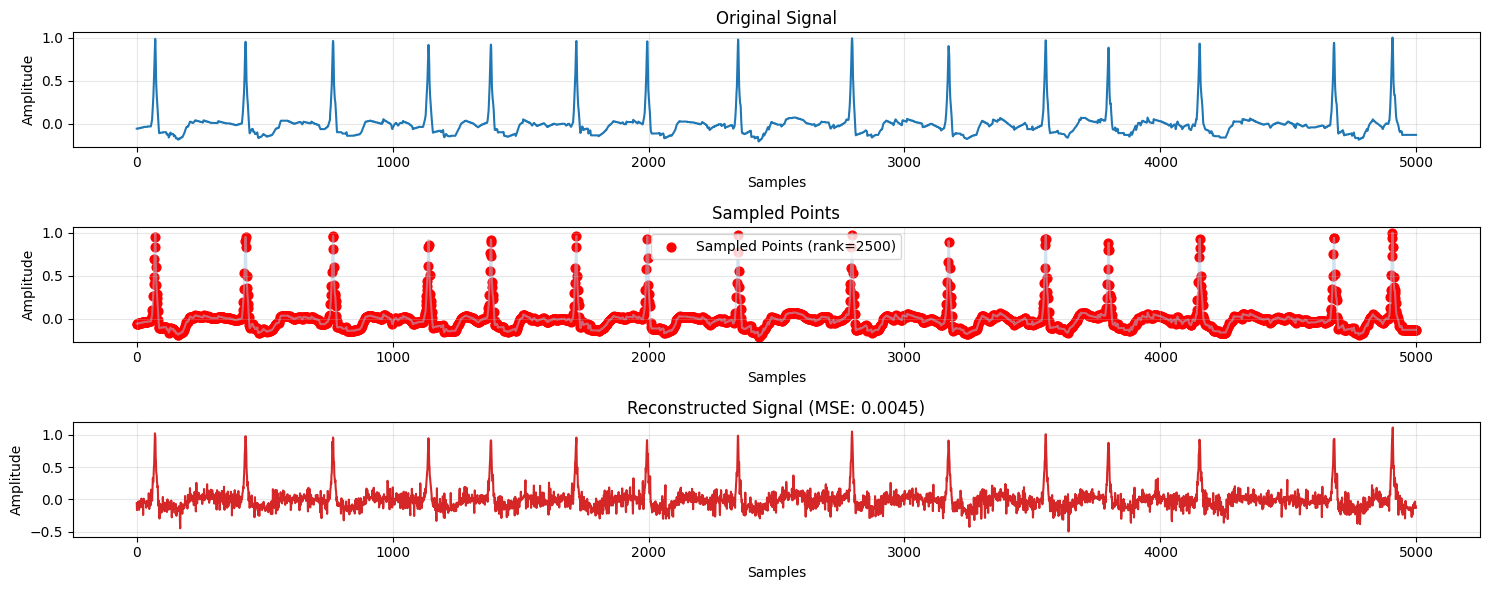


Analysis complete
Superclass: HYP
Test Record: 21797
Sampling Rate: 500Hz
Training Records Used: 2500
Rank: 2500
MSE: 0.0045


np.float64(0.004452000687820323)

In [ ]:
analyze_superclass_all_dirs(
        test_record=21797,
        sampling_rate=500,
        num_train_records=2500,
        rank=2500,
        superclass='HYP'
    )


Loading 4000 MI records from all directories...


Scanning MI directories:  73%|███████▎  | 16/22 [00:06<00:02,  2.50it/s]


Training model...
Locating test record 10030...
Reconstructing signal...


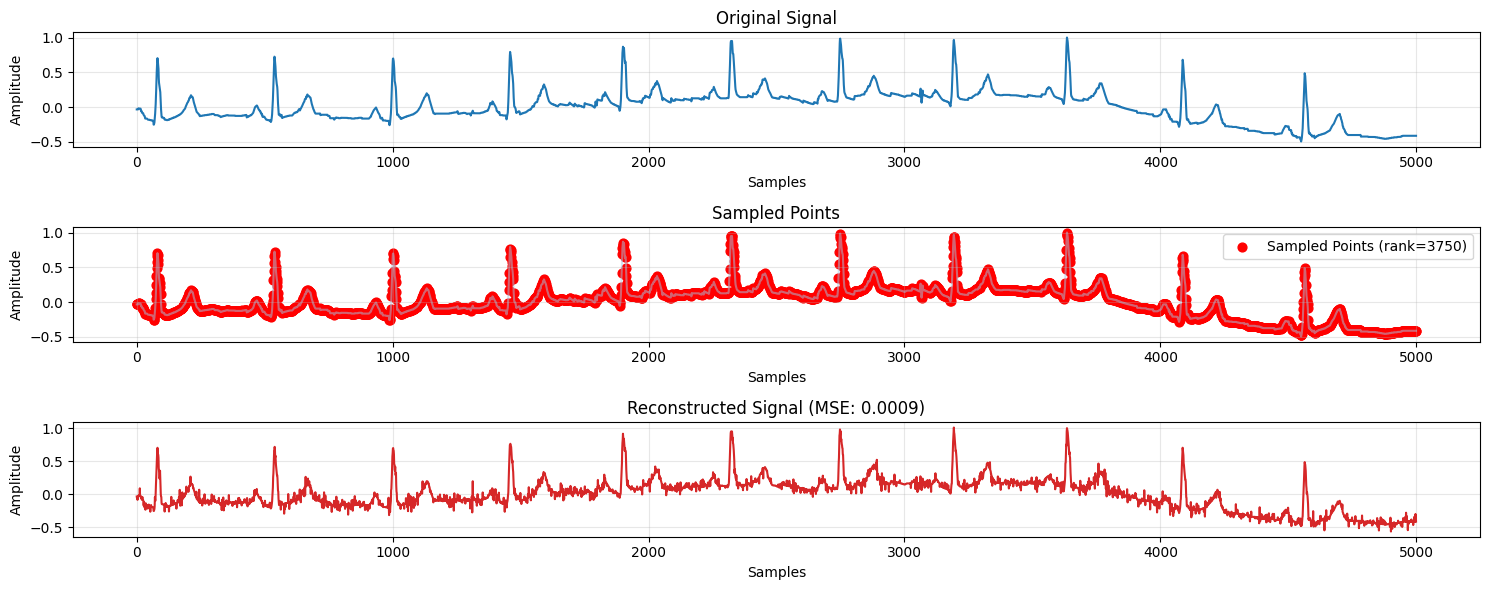


Analysis complete
Superclass: MI
Test Record: 10030
Sampling Rate: 500Hz
Training Records Used: 4000
Rank: 3750
MSE: 0.0009


np.float64(0.0009302571794558051)

In [ ]:
analyze_superclass_all_dirs(
        test_record=21797,
        sampling_rate=500,
        num_train_records=2500,
        rank=237500,
        superclass='HYP'
    )